# Data Cleaning

In [1]:
import sys
sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load ข้อมูล

In [3]:
df = pd.read_parquet('./dataset/train_data.parquet')

In [4]:
df.sample(5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
2382210,6e01783b71157001306918fa62ba5df4f1794d88d29f2f...,2017-11-20,0.888884,0.036563,0.011768,0.425232,0.007077,0.036435,0.006019,0.075442,...,NaN,NaN,0.002162,0.000545,0.000533,NaN,0.000635,0.000019,0.009343,0
1014705,2ee94f5a735c01c29f45f3e06c3483b6a6cf26887c0e5b...,2018-01-19,0.916681,0.009173,0.005979,0.812944,0.001421,NaN,0.006551,0.010381,...,NaN,NaN,0.001060,0.004465,0.000907,NaN,0.001792,0.005482,0.008818,0
1251651,39af6716ac4a57cfa8adfe985a88b1fe1eeaae87045010...,2017-07-01,0.822644,0.004728,0.026726,0.764764,0.005853,0.173160,0.000962,0.016531,...,NaN,NaN,0.004912,0.000148,0.003946,NaN,0.002558,0.006244,0.008075,0
4570577,d35318acd0ca071596a66f322426bfa05df21b1cf57663...,2018-03-07,0.969366,0.009730,0.127849,1.005911,0.009707,0.064149,0.004848,0.008932,...,NaN,NaN,0.007348,0.003264,0.009352,NaN,0.007897,0.005605,0.009782,0
4309705,c735c87431a250a8428e5e90e855a01396be071e5edda5...,2018-01-20,0.965779,0.359452,0.090811,0.140428,0.002306,0.140427,0.004304,0.132523,...,NaN,NaN,0.006274,0.003980,0.002306,NaN,0.009149,0.000417,0.006280,0


In [5]:
#df.describe()

**Features (ตัวแปร) ทุกตัวในชุดข้อมูลนี้ ทาง American Express ได้ทำให้เป็นแบบนิรนาม (anonymised) เพื่อลดความสุ่มเสี่ยงต่อการละเมิดความเป็นส่วนตัวของเจ้าของข้อมูล และได้ทำการปรับช่วงข้อมูลของแต่ละ features ให้อยู่ในช่วงเดียวกัน (normalised) ไว้เรียบร้อยแล้ว**

**ในชุดข้อมูลนี้ มีข้อมูล 4 ประเภท ได้แก่:**  
1. Feature ชื่อ customer_ID
2. Feature ชื่อ S_2 ซึ่งมีชนิดเป็นวันที่ (datetime)
3. มี 11 features ที่เป็นชนิดข้อมูลกลุ่ม (categorical data): B_30, B_38, D_114, D_116, D_117, D_120, D_126, D_63, D_64, D_66, D_68
4. อีก 178 features ที่เหลือเป็นชนิดเลขทศนิยม (float) และเลขจำนวนเต็ม (int)

ดังนั้น เราจึงต้องเปลี่ยนชนิดข้อมูล (data types) ให้ถูกประเภทก่อน จึงจะสามารถนำค่าเหล่านี้ไปใช้งานได้

## ทำการเปลี่ยนชนิดข้อมูลให้ถูกประเภท

เปลี่ยน feature ชื่อ S_2 ให้มีชนิดเป็นวันที่ (datetime):

In [6]:
df['S_2'] = pd.to_datetime(df['S_2'], format='%Y-%m-%d')

เปลี่ยน features ชื่อ B_30, B_38, D_114, D_116, D_117, D_120, D_126, D_63, D_64, D_66, D_68 ให้มีชนิดเป็น category:

In [7]:
category_cols = ['B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68']

for col in category_cols:
    df[col] = df[col].astype('category')

ตรวจดูชนิดข้อมูล (data types) ของ features ทุกตัว:

In [8]:
#df.info(max_cols=200, show_counts=True)

จากผลลัพธ์ df.info ข้างบนพบว่า features ทุกตัวในชุดข้อมูลนี้ มีชนิดข้อมูลที่ถูกประเภทแล้ว

ถัดไปเราจะกำจัด missing values เพื่อกำจัด category ที่เป็น null ก่อนจะเปลี่ยน categorical data ให้เป็น dummy variables

## การจัดการกับค่าที่หายไป (Missing Value)

In [9]:
pd.options.display.max_rows = None # output unlimited rows

percent_missing = df.isnull().sum() * 100 / len(df)
df_missing_val = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

โค้ดข้างล่างนี้ สามารถแสดงอัตราส่วนร้อยละของค่าที่หายไป (missing value) สำหรับแต่ละ feature:

In [10]:
pd.reset_option('display.max_columns')
# disable output unlimited columns

วาดกราฟเพื่อดูอัตราส่วนร้อยละของค่าที่หายไป (missing value) สำหรับแต่ละ feature:

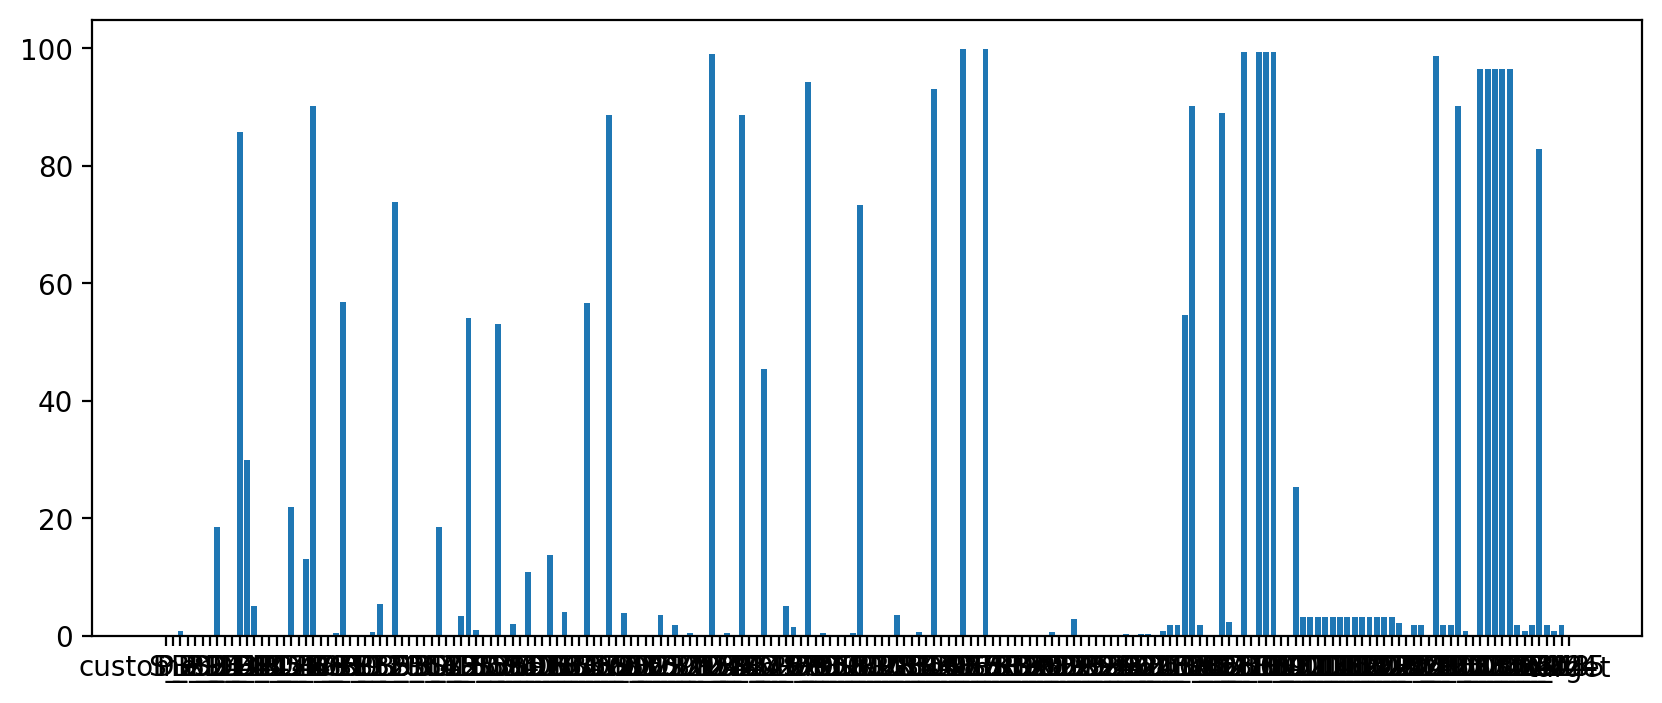

In [11]:
plt.figure(figsize=(10,4))
plt.bar(x='column_name',height='percent_missing',data=df_missing_val)
plt.show()

พิจารณาจำนวน features ที่มีค่าที่หายไป (null) มากกว่า 50% ของ feature นั้น ๆ:

In [12]:
df_missing_val.loc[df_missing_val.percent_missing > 50].shape[0]

30

พบว่ามี 30 features ที่มีค่า null มากกว่า 50% ของ feature นั้น ๆ

ทำการลบ features ที่มีค่า null มากกว่า 50% ของ feature นั้น ๆ ทิ้ง:

In [13]:
df.drop(
    columns=df_missing_val.loc[
        df_missing_val.percent_missing > 50
    ].index, inplace=True, errors='ignore'
)

จากนั้นลบแถวของข้อมูลที่เหลือ ที่ยังคงมี null หลงเหลืออยู่:

In [14]:
df.dropna(inplace=True)

ตรวจสอบขนาดของชุดข้อมูลหลังจากกำจัดค่าที่หายไป (missing value) แล้ว:

In [15]:
df.shape

(1301619, 161)

พบว่า จาก dataset ขนาด (5531451, 191) ลดลงเหลือ (1301619, 161)  
นั่นคือ ยังเหลือข้อมูลจำนวนมากพอสำหรับ train

### หาอัตราส่วนของ target (ลูกค้าที่ผิดนัดชำระ กับลูกค้าที่ไม่ผิดนัดชำระ)

หาอัตราส่วน target หลังจากจัดการกับค่าที่หายไป (missing values) แล้ว:

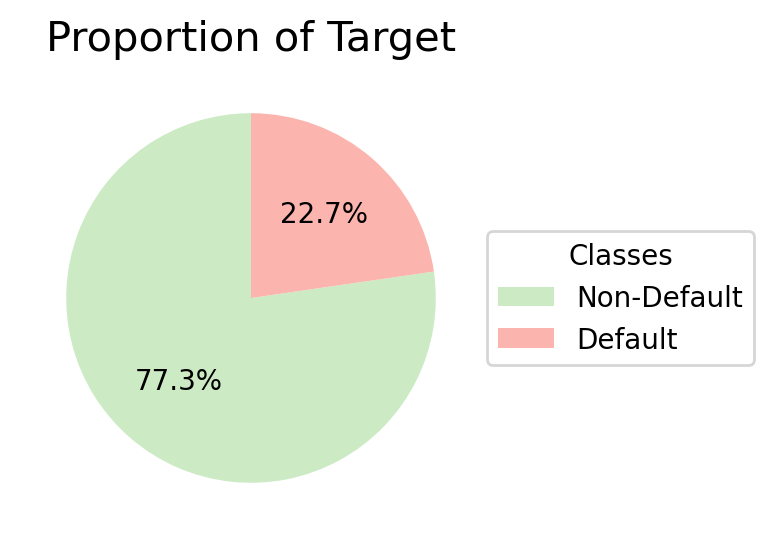

In [16]:
plt.figure(figsize=(3,3))

plt.pie(df['target'].value_counts(), colors=plt.cm.Pastel1([2,0]),
        autopct='%1.1f%%', startangle=90,
        textprops=dict(color='k', size=10))

plt.legend(['Non-Default','Default'], loc='center', bbox_to_anchor=(1.3,0.5),
           title='Classes')
plt.title('Proportion of Target', fontsize=15)
plt.show()

พบว่า ข้อมูลที่เหลืออยู่ เป็นลูกค้าที่ผิดนัดชำระ 22.7% และลูกค้าที่ไม่ผิดนัดชำระ 77.3%

แสดงว่าชุดข้อมูลนี้มีสัดส่วนข้อมูลไม่สมดุล (imbalanced dataset) เนื่องจาก target มีลูกค้าที่ผิดนัดชำระเป็นจำนวนน้อยกว่ามาก (ซึ่งเป็นไปตามธรรมชาติของโลกตามความเป็นจริง) การที่มีสัดส่วนข้อมูลที่ไม่สมดุล จะทำให้ความแม่นยำของการทำนายลดลง ซึ่งเป็นปัญหาที่พบได้บ่อยในงาน data science

## สร้าง dummy variables

เนื่องจาก Classification Models ไม่สามารถทำงานกับ categorical data ได้ ดังนั้น ขั้นตอนต่อไปต้องแปลง categorical data เหล่านี้ให้เป็นข้อมูลชนิดตัวเลข (numerical data) ด้วยเปลี่ยนให้เป็น dummy variables เพราะไม่สามารถ map ค่าเป็น 0,1,2,3,4,... ได้ เพราะจะทำให้ model จะให้ความสำคัญกับเลขจำนวนมาก มากกว่าเลขจำนวนน้อย ซึ่งจะกลายเป็น numerical data แทน แล้วจะเกิดปัญหา bias ใน model (เนื่องจากหากเป็น categorical data แล้ว ทุก labels จะต้องสำคัญเท่ากันหมด)

แสดง features ที่เป็นชนิด category:

In [17]:
df.select_dtypes(include=['category']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 1301619 entries, 19 to 5531450
Data columns (total 10 columns):
 #   Column  Non-Null Count    Dtype   
---  ------  --------------    -----   
 0   D_63    1301619 non-null  category
 1   D_64    1301619 non-null  category
 2   D_68    1301619 non-null  category
 3   B_30    1301619 non-null  category
 4   B_38    1301619 non-null  category
 5   D_114   1301619 non-null  category
 6   D_116   1301619 non-null  category
 7   D_117   1301619 non-null  category
 8   D_120   1301619 non-null  category
 9   D_126   1301619 non-null  category
dtypes: category(10)
memory usage: 22.3 MB


ตรวจสอบ categories ในแต่ละ categorical feature:

In [18]:
for col in ['D_63','D_64','D_68',
            'B_30','B_38',
            'D_114','D_116','D_117','D_120','D_126']:
    print(col,':',df[col].unique(),'\n')

D_63 : ['CO', 'CR', 'CL', 'XL', 'XZ', 'XM']
Categories (6, object): ['CL', 'CO', 'CR', 'XL', 'XM', 'XZ'] 

D_64 : ['O', 'R', 'U', '-1']
Categories (4, object): ['-1', 'O', 'R', 'U'] 

D_68 : [6.0, 2.0, 3.0, 5.0, 0.0, 4.0, 1.0]
Categories (7, float32): [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 

B_30 : [0.0, 1.0, 2.0]
Categories (3, float32): [0.0, 1.0, 2.0] 

B_38 : [2.0, 3.0, 5.0, 1.0, 4.0, 7.0, 6.0]
Categories (7, float32): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0] 

D_114 : [1.0, 0.0]
Categories (2, float32): [0.0, 1.0] 

D_116 : [0.0, 1.0]
Categories (2, float32): [0.0, 1.0] 

D_117 : [-1.0, 6.0, 4.0, 3.0, 2.0, 1.0, 5.0]
Categories (7, float32): [-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0] 

D_120 : [0.0, 1.0]
Categories (2, float32): [0.0, 1.0] 

D_126 : [1.0, -1.0, 0.0]
Categories (3, float32): [-1.0, 0.0, 1.0] 



สร้าง dummy variables โดย drop_first เพื่อป้องกันปัญหา multi-collinearity (การมีสหสัมพันธ์กันเองระหว่างตัวแปรอิสระ) ซึ่งจะทำให้ model มีความคลาดเคลื่อนได้:

In [19]:
df = pd.get_dummies(df, columns=['D_63','D_64','D_68',
                                 'B_30','B_38',
                                 'D_114','D_116','D_117','D_120','D_126'], drop_first=True)
# drop_first=True in order to prevent the Multi-collinearity problem

แสดงชื่อ features ทั้งหมดของชุดข้อมูลที่จะนำไปใช้สร้างโมเดลในขั้นตอนต่อไป:

In [20]:
df.columns.values

array(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3',
       'D_41', 'B_3', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46',
       'D_47', 'D_48', 'B_6', 'B_7', 'B_8', 'D_51', 'B_9', 'R_3', 'D_52',
       'P_3', 'B_10', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12',
       'S_8', 'D_55', 'B_13', 'R_5', 'D_58', 'B_14', 'D_59', 'D_60',
       'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_18', 'B_19',
       'B_20', 'S_12', 'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70',
       'D_71', 'D_72', 'S_15', 'B_23', 'P_4', 'D_74', 'D_75', 'B_24',
       'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_16',
       'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'S_17', 'R_12', 'B_28',
       'R_13', 'D_83', 'R_14', 'R_15', 'D_84', 'R_16', 'S_18', 'D_86',
       'R_17', 'R_18', 'B_31', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20',
       'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93',
       'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25',
 